<a href="https://colab.research.google.com/github/Sivani2499/Predictive-model-gene-expression/blob/main/Predicting%20heart%20disease%20and%20their%20combined%20relation%20with%20DM%20and%20HTN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, roc_auc_score
)


In [2]:

df = pd.read_sas('/content/LLCP2015.XPT ', format='xport')

print(df.shape)
df.head()

(441456, 330)


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,1.0,1.0,b'01292015',b'01',b'29',b'2015',1200.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0
1,1.0,1.0,b'01202015',b'01',b'20',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,2.0,2.0,3.0,3.0,4.0,2.0,2.0,NaN,NaN,2.0
2,1.0,1.0,b'02012015',b'02',b'01',b'2015',1200.0,2.015000e+09,2.015000e+09,1.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN
3,1.0,1.0,b'01142015',b'01',b'14',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,9.0
4,1.0,1.0,b'01142015',b'01',b'14',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441456 entries, 0 to 441455
Columns: 330 entries, _STATE to _AIDTST3
dtypes: float64(323), object(7)
memory usage: 1.1+ GB


In [4]:

df['CVDINFR4_clean'] = pd.to_numeric(df['CVDINFR4'], errors='coerce')
df['CVDCRHD4_clean'] = pd.to_numeric(df['CVDCRHD4'], errors='coerce')
yes_no_cvd = {1: 1, 2: 0, 7: np.nan, 9: np.nan}
#yes_no_cvd = {1: 'Yes', 2: 'No', 7: np.nan, 9: np.nan}
df['CVDINFR4_clean'] = df['CVDINFR4'].map(yes_no_cvd)
df['CVDCRHD4_clean'] = df['CVDCRHD4'].map(yes_no_cvd)
df['HeartDisease'] = df[['CVDINFR4_clean', 'CVDCRHD4_clean']].max(axis=1)

print(df['HeartDisease'].unique())

[ 0.  1. nan]


In [5]:
def create_heart_disease_custom(row):
    cvd_infr = row['CVDINFR4_clean']  # Heart attack
    cvd_crhd = row['CVDCRHD4_clean']  # Coronary heart disease

    # If either is 1, person has heart disease
    if cvd_infr == 1 or cvd_crhd == 1:
        return 1

    # If both are NaN, return NaN (unknown)
    elif pd.isna(cvd_infr) and pd.isna(cvd_crhd):
        return np.nan

    # All other cases: (0,0), (0,NaN), (NaN,0) -> return 0
    else:
        return 0


df['HeartDisease'] = df.apply(create_heart_disease_custom, axis=1)
print(df['HeartDisease'].unique())

[ 0.  1. nan]


In [6]:
print("Heart Disease Distribution with Custom Logic:")
print(df['HeartDisease'].value_counts(dropna=False))
print(f"\nMissing values: {df['HeartDisease'].isna().sum()}")
print(f"Heart disease rate (among non-missing): {df['HeartDisease'].mean():.3f}")

print("\n" + "="*60)
print("VERIFICATION: Cross-tabulation of input vs output")
print("="*60)


Heart Disease Distribution with Custom Logic:
HeartDisease
0.0    402358
1.0     38633
NaN       465
Name: count, dtype: int64

Missing values: 465
Heart disease rate (among non-missing): 0.088

VERIFICATION: Cross-tabulation of input vs output


In [7]:
#Renaming variables and selecting only the required ones for this model
var_map = {
    'Diabetic':         'DIABETE3',
    'HighBP':           'BPHIGH4',
    'HighCholesterol':   'TOLDHI2',
    #'BMI':              '_BMI5',
    'PhysicalActivity': 'EXERANY2',
    #'Sleepquality' : "ADSLEEP",
    'GenHealth':        'GENHLTH',
    'MentalHealth':     'MENTHLTH',
    'AgeCategory':      '_AGEG5YR',
    'Sex':              'SEX',
    'Education':        'EDUCA',
    'Income':           'INCOME2',
    'Race':             '_PRACE1',
    #'CVDInfarction':    'CVDINFR4',
    #'CVDCorHD':         'CVDCRHD4',
    'INCOMG':           '_INCOMG',
    'HealthCoverage':   'HLTHPLN1',
    'MedCostBarrier':   'MEDCOST',
    'MaritalStatus':    'MARITAL',
    'Employment':       'EMPLOY1',
    'SmokerStatus':     '_SMOKER3',
    'DrinksPerDay':        'AVEDRNK2',
    'HispanicOrigin':   '_HISPANC',
    # Outcome
    'HeartDisease':     'HeartDisease'
}

filtered_df = df[list(var_map.values())].rename(columns={v:k for k,v in var_map.items()})
print("After subsetting:", filtered_df.shape)
filtered_df.head()

After subsetting: (441456, 20)


,Diabetic,HighBP,HighCholesterol,PhysicalActivity,GenHealth,MentalHealth,AgeCategory,Sex,Education,Income,Race,INCOMG,HealthCoverage,MedCostBarrier,MaritalStatus,Employment,SmokerStatus,DrinksPerDay,HispanicOrigin,HeartDisease
0,3.0,1.0,1.0,2.0,5.0,18.0,9.0,2.0,4.0,3.0,1.0,2.0,1.0,2.0,1.0,8.0,3.0,NaN,2.0,0.0
1,3.0,3.0,2.0,1.0,3.0,88.0,7.0,2.0,6.0,1.0,1.0,1.0,2.0,1.0,2.0,3.0,1.0,NaN,2.0,0.0
2,3.0,3.0,1.0,NaN,4.0,88.0,11.0,2.0,4.0,99.0,1.0,9.0,1.0,2.0,2.0,7.0,9.0,NaN,2.0,0.0
3,3.0,1.0,1.0,2.0,5.0,30.0,9.0,2.0,4.0,8.0,1.0,5.0,1.0,1.0,1.0,8.0,4.0,NaN,2.0,0.0
4,3.0,3.0,2.0,2.0,5.0,88.0,9.0,2.0,5.0,77.0,1.0,9.0,1.0,2.0,1.0,8.0,4.0,NaN,2.0,0.0


In [8]:
filtered_df['HeartDisease'].unique()

array([ 0.,  1., nan])

#loading categoricalDtype
#applying categories to conditions and setting an order for each of the variables

In [9]:
from pandas.api.types import CategoricalDtype

In [10]:
filtered_df['Diabetic'] = pd.to_numeric(filtered_df['Diabetic'], errors='coerce')

diab = {
    1: 'Chronic',       # Yes, non-pregnancy
    2: 'gestational',   # Yes, pregnancy only
    3: 'none',          # No
    4: 'prediabetes',   # Borderline/pre-diabetes
    7: np.nan,          # Don’t know
    9: np.nan,           # Refused / missing
    "BLANK" : np.nan
}

filtered_df['DiabetesStatus'] = filtered_df['Diabetic'].map(diab)

diab_cat = CategoricalDtype(
    ['none','Chronic', 'gestational' ,'prediabetes'],
    ordered=True
)

filtered_df['DiabetesStatus'] = filtered_df['DiabetesStatus'].astype(diab_cat)

print(filtered_df['DiabetesStatus'].unique())


['none', 'Chronic', 'prediabetes', 'gestational', NaN]
Categories (4, object): ['none' < 'Chronic' < 'gestational' < 'prediabetes']


In [11]:
filtered_df['HighBP'] = pd.to_numeric(filtered_df['HighBP'], errors='coerce')

hyp = {
    1: 'Yes',
    2: 'Preeclampsia',
    3: 'none',
    4: 'Pre-hypertensive',
    7: np.nan,
    9: np.nan
}

filtered_df['Hypertension'] = filtered_df['HighBP'].map(hyp)

hyp_cat = CategoricalDtype(
    ['none','Yes', 'Preeclampsia', 'Pre-hypertensive'],
    ordered=True
)

filtered_df['Hypertension'] = filtered_df['Hypertension'].astype(hyp_cat)
print(filtered_df['Hypertension'].unique())

['Yes', 'none', NaN, 'Preeclampsia', 'Pre-hypertensive']
Categories (4, object): ['none' < 'Yes' < 'Preeclampsia' < 'Pre-hypertensive']


In [12]:
filtered_df['PhysicalActivity'] = pd.to_numeric(filtered_df['PhysicalActivity'], errors='coerce')

yes_no = {1: 'Yes', 2: 'No', 7: np.nan, 9: np.nan}

filtered_df['PhysicalActivity']= filtered_df['PhysicalActivity'].map(yes_no)

phys_cat = CategoricalDtype(
    ['Yes', 'No'],
    ordered=True
)

filtered_df['PhysicalActivity'] = filtered_df['PhysicalActivity'].astype(phys_cat)

print(filtered_df['PhysicalActivity'].unique())

['No', 'Yes', NaN]
Categories (2, object): ['Yes' < 'No']


In [13]:
filtered_df['HighCholesterol'] = pd.to_numeric(filtered_df['HighCholesterol'], errors='coerce')
chol = {1: 'Yes', 2: 'No', 7: np.nan, 9: np.nan}

filtered_df['HighCholesterol_'] = filtered_df['HighCholesterol'].map(chol)

chol_cat = CategoricalDtype(
    ['No','Yes'],
    ordered=True
)

filtered_df['HighCholesterol_'] = filtered_df['HighCholesterol_'].astype(chol_cat)
print(filtered_df['HighCholesterol_'].unique())

['Yes', 'No', NaN]
Categories (2, object): ['No' < 'Yes']


DOnt run sleep quality as it has lot of missing values

In [14]:
filtered_df['Sleepquality'] = pd.to_numeric(filtered_df['Sleepquality'], errors='coerce')

filtered_df['Sleepquality'] = filtered_df['Sleepquality'].replace({77: np.nan, 99: np.nan, 88: 0 })

def categorize_sleep(days):
    if pd.isna(days):
        return np.nan
    elif days <= 2:
        return 'Good'
    elif days <= 7:
        return 'Moderate'
    elif days <= 14:
        return 'Poor'
    else:
        return np.nan

filtered_df['Sleepquality'] = filtered_df['Sleepquality'].apply(categorize_sleep)

sleep_cat = CategoricalDtype(
    ['Good', 'Moderate', 'Poor'],
    ordered=True
)

filtered_df['Sleepquality'] = filtered_df['Sleepquality'].astype(sleep_cat)

print(filtered_df['Sleepquality'].unique())

KeyError: 'Sleepquality'

In [ ]:
filtered_df['Sleepquality'].value_counts(dropna=False)


#Run from here


In [15]:
filtered_df['GenHealth'] = pd.to_numeric(filtered_df['GenHealth'], errors='coerce')
gh = {
    1: 'Excellent',
    2: 'Very Good',
    3: 'Good',
    4: 'Fair',
    5: 'Poor',
    7: np.nan,
    9: np.nan
}

filtered_df['GenHealth'] = filtered_df['GenHealth'].map(gh)

gh_cat = CategoricalDtype(
    ['Excellent','Very Good','Good','Fair','Poor'],
    ordered=True
)

filtered_df['GenHealth'] = filtered_df['GenHealth'].astype(gh_cat)
print(filtered_df['GenHealth'].unique())

['Poor', 'Good', 'Fair', 'Very Good', 'Excellent', NaN]
Categories (5, object): ['Excellent' < 'Very Good' < 'Good' < 'Fair' < 'Poor']


In [16]:
filtered_df['MentalHealth'] = pd.to_numeric(filtered_df['MentalHealth'], errors='coerce')
filtered_df['MentalHealth'] = filtered_df['MentalHealth'].replace({
    88: 0,
    77: np.nan,
    99: np.nan,
    777: np.nan,
    9999: np.nan  # precautionary
})
def categorize_mental_health(days):
    if pd.isna(days):
        return 'Unknown'
    elif days == 0:
        return 'None'
    elif 1 <= days <= 7:
        return 'Mild'
    elif 8 <= days <= 14:
        return 'Moderate'
    elif days >= 15:
        return 'Frequent'
    else:
        return 'Unknown'

filtered_df['MentalHealth'] = filtered_df['MentalHealth'].apply(categorize_mental_health)

mental_cat = CategoricalDtype(
    ['None','Mild', 'Moderate', 'Frequent','Unknown'],
    ordered=True
)

filtered_df['MentalHealth'] = filtered_df['MentalHealth'].astype(mental_cat)
print(filtered_df['MentalHealth'].unique())

['Frequent', 'None', 'Mild', 'Unknown', 'Moderate']
Categories (5, object): ['None' < 'Mild' < 'Moderate' < 'Frequent' < 'Unknown']


In [17]:
filtered_df['AgeCategory'] = pd.to_numeric(filtered_df['AgeCategory'], errors='coerce')
age_map = {
    1:'18-24',  2:'25-29',  3:'30-34',  4:'35-39',  5:'40-44',
    6:'45-49',  7:'50-54',  8:'55-59',  9:'60-64', 10:'65-69',
    11:'70-74', 12:'75-79', 13:'80+', 14: np.nan
}
filtered_df['AgeCategory_'] = filtered_df['AgeCategory'].map(age_map)
age_order = ['18-24', '25-29', '30-34', '35-39', '40-44',
             '45-49', '50-54', '55-59', '60-64', '65-69',
             '70-74', '75-79', '80+']
filtered_df['AgeCategory_'] = pd.Categorical(filtered_df['AgeCategory_'], categories=age_order, ordered=True)


print(filtered_df['AgeCategory_'].cat.categories)
#print(filtered_df['AgeCategory_'].unique())

Index(['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59',
       '60-64', '65-69', '70-74', '75-79', '80+'],
      dtype='object')


In [18]:
filtered_df['Sex'] = pd.to_numeric(filtered_df['Sex'], errors='coerce')
filtered_df['Sex']   = filtered_df['Sex'].map({1:'Male', 2:'Female'})
sex_order = ['Male', 'Female']
filtered_df['Sex'] = pd.Categorical(filtered_df['Sex'], categories=sex_order, ordered=True)
print(filtered_df['Sex'].cat.categories)

Index(['Male', 'Female'], dtype='object')


In [19]:
filtered_df['Education'] = pd.to_numeric(filtered_df['Education'], errors='coerce')

edu ={
    1: 'No Schooling',
    2: 'Grades 1 through 8',
    3: 'Grades 9 through 11 ',
    4: 'High school graduate',
    5: 'College 1 year to 3 years',
    6: 'College graduate',
    9: 'Refused',
}

filtered_df['Education_'] = filtered_df['Education'].map(edu)

age_cat = CategoricalDtype(
    ['College graduate', 'No Schooling','Grades 1 through 8', 'Grades 9 through 11 ', 'High school graduate',
     'College 1 year to 3 years' ],
    ordered=True
)

filtered_df['Education_'] = filtered_df['Education_'].astype(age_cat)
print(filtered_df['Education_'].cat.categories)
print(filtered_df['Education_'].unique())

Index(['College graduate', 'No Schooling', 'Grades 1 through 8',
       'Grades 9 through 11 ', 'High school graduate',
       'College 1 year to 3 years'],
      dtype='object')
['High school graduate', 'College graduate', 'College 1 year to 3 years', 'Grades 9 through 11 ', 'Grades 1 through 8', NaN, 'No Schooling']
Categories (6, object): ['College graduate' < 'No Schooling' < 'Grades 1 through 8' <
                         'Grades 9 through 11 ' < 'High school graduate' < 'College 1 year to 3 years']


In [20]:
filtered_df['Income'] = pd.to_numeric(filtered_df['Income'], errors='coerce')
Inc = {
    1: 'Less than $10,000',
    2: 'Less than $15,000',
    3: 'Less than $20,000',
    4: 'Less than $25,000',
    5: 'Less than $35,000',
    6: 'Less than $50,000',
    7: 'Less than $75,000',
    8: '$75,000 or more',
    77: np.nan,
    99: np.nan
}

filtered_df['Income_'] = filtered_df['Income'].map(Inc)

inc_cat = CategoricalDtype(
    [ '$75,000 or more', 'Less than $10,000', 'Less than $15,000', 'Less than $20,000','Less than $25,000', 'Less than $35,000',
     'Less than $50,000', 'Less than $75,000'],
    ordered=True
)

filtered_df['Income_'] = filtered_df['Income_'].astype(inc_cat)
print(filtered_df['Income_'].unique())


['Less than $20,000', 'Less than $10,000', NaN, '$75,000 or more', 'Less than $50,000', 'Less than $25,000', 'Less than $75,000', 'Less than $35,000', 'Less than $15,000']
Categories (8, object): ['$75,000 or more' < 'Less than $10,000' < 'Less than $15,000' <
                         'Less than $20,000' < 'Less than $25,000' < 'Less than $35,000' <
                         'Less than $50,000' < 'Less than $75,000']


In [21]:
filtered_df['Race'] = pd.to_numeric(filtered_df['Race'], errors='coerce')
race = {
    1: 'White',
    2: 'Black',
    3: 'American Indian/Alaskan native',
    4: 'Asian',
    5: 'Native Hawaiian or other Pacific Islander',
    6:'Other race',
    7: 'no preferred race',
    8: 'Multiracial',
    77: np.nan,
    99: np.nan
}

filtered_df['Race_'] = filtered_df['Race'].map(race)
print(filtered_df['Race_'].unique())

['White' 'Black' 'American Indian/Alaskan native' nan 'no preferred race'
 'Other race' 'Asian' 'Native Hawaiian or other Pacific Islander'
 'Multiracial']


##Don't run this

In [ ]:
#infarction = {
    1: 'Yes',
    2: 'No',
    7: np.nan,
    9: np.nan
}

filtered_df['CVDInfarction_'] = filtered_df['CVDInfarction'].map(infarction)

In [ ]:
#chd = {
    1: 'Yes',
    2: 'No',
    7: np.nan,
    9: np.nan
}

filtered_df['CVDCorHD_'] = filtered_df['CVDCorHD'].map(chd)

#Run from here

In [22]:
filtered_df['HealthCoverage'] = pd.to_numeric(filtered_df['HealthCoverage'], errors='coerce')
hlthpln = {
    1: 'Yes',
    2: 'No',
    7: np.nan,
    9: np.nan
}

filtered_df['HealthCoverage_'] = filtered_df['HealthCoverage'].map(hlthpln)

hlth_cat = CategoricalDtype(
    ['Yes','No'],
    ordered=True
)

filtered_df['HealthCoverage_'] = filtered_df['HealthCoverage_'].astype(hlth_cat)

print(filtered_df['HealthCoverage_'].unique())

['Yes', 'No', NaN]
Categories (2, object): ['Yes' < 'No']


In [23]:
filtered_df['MedCostBarrier'] = pd.to_numeric(filtered_df['MedCostBarrier'], errors='coerce')
medcost = {
    1: 'Yes',
    2: 'No',
    7: np.nan,
    9: np.nan
}

filtered_df['MedCostBarrier_'] = filtered_df['MedCostBarrier'].map(medcost)
med_cat = CategoricalDtype(
    ['No','Yes'],
    ordered=True
)

filtered_df['MedCostBarrier_'] = filtered_df['MedCostBarrier_'].astype(med_cat)
print(filtered_df['MedCostBarrier_'].unique())

['No', 'Yes', NaN]
Categories (2, object): ['No' < 'Yes']


In [24]:
filtered_df['MaritalStatus'] = pd.to_numeric(filtered_df['MaritalStatus'], errors='coerce')
marital = {
    1: 'Married',
    2: 'Divorced',
    3: 'Widowed',
    4: 'Separated',
    5: 'Never married',
    6: 'Living with partner',
    9: np.nan
}

filtered_df['MaritalStatus_'] = filtered_df['MaritalStatus'].map(marital)
marital_cat = CategoricalDtype(
    [ 'Never married','Married', 'Divorced', 'Widowed', 'Separated', 'Living with partner'],
    ordered=True
)

filtered_df['MaritalStatus_'] = filtered_df['MaritalStatus_'].astype(marital_cat)

print(filtered_df['MaritalStatus_'].unique())

['Married', 'Divorced', 'Widowed', 'Living with partner', 'Never married', 'Separated', NaN]
Categories (6, object): ['Never married' < 'Married' < 'Divorced' < 'Widowed' < 'Separated' <
                         'Living with partner']


In [25]:
filtered_df['Employment'] = pd.to_numeric(filtered_df['Employment'], errors='coerce')
employ ={
    1: 'Employed for wages',
    2: 'Self - employed',
    3: 'Divorced',
    4: 'Out of work for less than 1 year',
    5: 'Homemaker',
    6: 'Student',
    7: 'Retired',
    8: 'Unable to work',
    9: np.nan
}

filtered_df['Employment_'] = filtered_df['Employment'].map(employ)

employ_cat = CategoricalDtype(
    ['Self - employed','Employed for wages', 'Divorced', 'Out of work for less than 1 year', 'Homemaker', 'Student', 'Retired', 'Unable to work'],
    ordered=True
)

filtered_df['Employment_'] = filtered_df['Employment_'].astype(employ_cat)
print(filtered_df['Employment_'].unique())

['Unable to work', 'Divorced', 'Retired', 'Self - employed', 'Homemaker', NaN, 'Employed for wages', 'Out of work for less than 1 year', 'Student']
Categories (8, object): ['Self - employed' < 'Employed for wages' < 'Divorced' <
                         'Out of work for less than 1 year' < 'Homemaker' < 'Student' < 'Retired' < 'Unable to work']


In [26]:
filtered_df['SmokerStatus'] = pd.to_numeric(filtered_df['SmokerStatus'], errors='coerce')
smoker = {
    1: 'Current everyday smoker',
    2:'Current some day smoker',
    3: 'Former smoker',
    4: 'Never smoked',
    9: np.nan
}

filtered_df['SmokerStatus_']= filtered_df['SmokerStatus'].map(smoker)

smoker_cat = CategoricalDtype(
    ['Never smoked','Current everyday smoker', 'Current some day smoker', 'Former smoker'],
    ordered=True
)

filtered_df['SmokerStatus_'] = filtered_df['SmokerStatus_'].astype(smoker_cat)
print(filtered_df['SmokerStatus_'].unique())

['Former smoker', 'Current everyday smoker', NaN, 'Never smoked', 'Current some day smoker']
Categories (4, object): ['Never smoked' < 'Current everyday smoker' < 'Current some day smoker' <
                         'Former smoker']


In [27]:
filtered_df['DrinksPerDay'] = pd.to_numeric(filtered_df['DrinksPerDay'], errors='coerce')
filtered_df['DrinksPerDay'] = filtered_df['DrinksPerDay'].replace({77: np.nan, 99: np.nan, 888: np.nan, 777: np.nan, 9999: np.nan})


def categorize_drinking(x):
    if pd.isna(x):
        return 'Unknown'
    elif x == 0:
        return 'None'
    elif 1 <= x <= 2:
        return 'Low'
    elif 3 <= x <= 4:
        return 'Moderate'
    elif x >= 5:
        return 'High'
    else:
        return 'Unknown'

filtered_df['DrinksPerDay'] = filtered_df['DrinksPerDay'].apply(categorize_drinking)

drinks_cat = CategoricalDtype(
    ['None','Low', 'Moderate', 'High','Unknown'],
    ordered=True
)

filtered_df['DrinksPerDay'] = filtered_df['DrinksPerDay'].astype(drinks_cat)

print(filtered_df['DrinksPerDay'].unique())

['Unknown', 'Low', 'Moderate', 'High']
Categories (5, object): ['None' < 'Low' < 'Moderate' < 'High' < 'Unknown']


In [28]:
filtered_df['HispanicOrigin'] = pd.to_numeric(filtered_df['HispanicOrigin'], errors='coerce')
hispanic = {
    1: 'Hispanic/Latino/Spanish',
    2: 'Not Hispanic/Latino/Spanish',
    9: np.nan
}

filtered_df['HispanicOrigin_'] = filtered_df['HispanicOrigin'].map(hispanic)

hispanic_cat = CategoricalDtype(
    ['Not Hispanic/Latino/Spanish','Hispanic/Latino/Spanish'],
    ordered=True
)

filtered_df['HispanicOrigin_'] = filtered_df['HispanicOrigin_'].astype(hispanic_cat)
print(filtered_df['HispanicOrigin_'].unique())

['Not Hispanic/Latino/Spanish', NaN, 'Hispanic/Latino/Spanish']
Categories (2, object): ['Not Hispanic/Latino/Spanish' < 'Hispanic/Latino/Spanish']


In [29]:
filtered_df.head()

,Diabetic,HighBP,HighCholesterol,PhysicalActivity,GenHealth,MentalHealth,AgeCategory,Sex,Education,Income,...,AgeCategory_,Education_,Income_,Race_,HealthCoverage_,MedCostBarrier_,MaritalStatus_,Employment_,SmokerStatus_,HispanicOrigin_
0,3.0,1.0,1.0,No,Poor,Frequent,9.0,Female,4.0,3.0,...,60-64,High school graduate,"Less than $20,000",White,Yes,No,Married,Unable to work,Former smoker,Not Hispanic/Latino/Spanish
1,3.0,3.0,2.0,Yes,Good,None,7.0,Female,6.0,1.0,...,50-54,College graduate,"Less than $10,000",White,No,Yes,Divorced,Divorced,Current everyday smoker,Not Hispanic/Latino/Spanish
2,3.0,3.0,1.0,NaN,Fair,None,11.0,Female,4.0,99.0,...,70-74,High school graduate,NaN,White,Yes,No,Divorced,Retired,NaN,Not Hispanic/Latino/Spanish
3,3.0,1.0,1.0,No,Poor,Frequent,9.0,Female,4.0,8.0,...,60-64,High school graduate,"$75,000 or more",White,Yes,Yes,Married,Unable to work,Never smoked,Not Hispanic/Latino/Spanish
4,3.0,3.0,2.0,No,Poor,None,9.0,Female,5.0,77.0,...,60-64,College 1 year to 3 years,NaN,White,Yes,No,Married,Unable to work,Never smoked,Not Hispanic/Latino/Spanish


In [30]:
filtered_df.columns

#filtered_df['CVDInfarction'].unique()

Index(['Diabetic', 'HighBP', 'HighCholesterol', 'PhysicalActivity',
       'GenHealth', 'MentalHealth', 'AgeCategory', 'Sex', 'Education',
       'Income', 'Race', 'INCOMG', 'HealthCoverage', 'MedCostBarrier',
       'MaritalStatus', 'Employment', 'SmokerStatus', 'DrinksPerDay',
       'HispanicOrigin', 'HeartDisease', 'DiabetesStatus', 'Hypertension',
       'HighCholesterol_', 'AgeCategory_', 'Education_', 'Income_', 'Race_',
       'HealthCoverage_', 'MedCostBarrier_', 'MaritalStatus_', 'Employment_',
       'SmokerStatus_', 'HispanicOrigin_'],
      dtype='object')

In [31]:
filtered_df['PhysicalActivity'].value_counts(normalize=True)


,proportion
PhysicalActivity,
Yes,0.733696
No,0.266304


In [32]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441456 entries, 0 to 441455
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Diabetic          441449 non-null  float64 
 1   HighBP            441455 non-null  float64 
 2   HighCholesterol   382302 non-null  float64 
 3   PhysicalActivity  403464 non-null  category
 4   GenHealth         440209 non-null  category
 5   MentalHealth      441456 non-null  category
 6   AgeCategory       441456 non-null  float64 
 7   Sex               441456 non-null  category
 8   Education         441456 non-null  float64 
 9   Income            438155 non-null  float64 
 10  Race              441456 non-null  float64 
 11  INCOMG            441456 non-null  float64 
 12  HealthCoverage    441456 non-null  float64 
 13  MedCostBarrier    441455 non-null  float64 
 14  MaritalStatus     441456 non-null  float64 
 15  Employment        441456 non-null  float64 
 16  Sm

In [33]:
missing = filtered_df.isnull().mean().sort_values(ascending=False)
print(missing)

Income_             0.180097
HighCholesterol_    0.142064
HighCholesterol     0.133997
PhysicalActivity    0.086061
SmokerStatus_       0.040752
Race_               0.019968
AgeCategory_        0.012087
HispanicOrigin_     0.009369
Employment_         0.008597
Income              0.007478
MaritalStatus_      0.007013
HealthCoverage_     0.004168
Education_          0.004102
Hypertension        0.003097
GenHealth           0.002825
MedCostBarrier_     0.002705
DiabetesStatus      0.001808
HeartDisease        0.001053
Diabetic            0.000016
HighBP              0.000002
MedCostBarrier      0.000002
SmokerStatus        0.000000
Employment          0.000000
Sex                 0.000000
Education           0.000000
AgeCategory         0.000000
MentalHealth        0.000000
MaritalStatus       0.000000
HealthCoverage      0.000000
Race                0.000000
INCOMG              0.000000
HispanicOrigin      0.000000
DrinksPerDay        0.000000
dtype: float64


#Filtering the dataset to remove repeated variables and just keeping the final ones

In [34]:

model_vars = [
    # Demographics
    'AgeCategory_', 'Sex', 'Race_', 'Education_', 'Income_', 'MaritalStatus_',
    # Health (use categorical versions for richer information)
    'DiabetesStatus', 'Hypertension', 'GenHealth', "HighCholesterol_", "MentalHealth",
    # Behavioral
    'PhysicalActivity', 'SmokerStatus_', 'DrinksPerDay',
    # Healthcare access
    'HealthCoverage_', 'MedCostBarrier_',
    # Other
    'Employment_', 'HispanicOrigin_',
    # Target
    'HeartDisease'
]

clean_df = filtered_df[model_vars].copy()


#Just an overview of heart disease by disease status (diabetes and hypertension)

In [35]:
print("Heart Disease by Diabetes Status:")
print(pd.crosstab(clean_df['DiabetesStatus'], clean_df['HeartDisease'], normalize='index'))

print("\nHeart Disease by Hypertension:")
print(pd.crosstab(clean_df['Hypertension'], clean_df['HeartDisease'], normalize='index'))

Heart Disease by Diabetes Status:
HeartDisease         0.0       1.0
DiabetesStatus                    
none            0.933250  0.066750
Chronic         0.781339  0.218661
gestational     0.961197  0.038803
prediabetes     0.858519  0.141481

Heart Disease by Hypertension:
HeartDisease           0.0       1.0
Hypertension                        
none              0.963077  0.036923
Yes               0.838419  0.161581
Preeclampsia      0.968492  0.031508
Pre-hypertensive  0.940808  0.059192


In [36]:
print(clean_df.duplicated().sum())

clean_df.shape

clean_df.describe().T

78339


,count,mean,std,min,25%,50%,75%,max
HeartDisease,440991.0,0.087605,0.28272,0.0,0.0,0.0,0.0,1.0


#To see the value counts of variables that are of types object and category

In [37]:
clean_df.select_dtypes(include=['object','category']) \
          .apply(lambda s: s.value_counts(dropna=False))

,AgeCategory_,Sex,Race_,Education_,Income_,MaritalStatus_,DiabetesStatus,Hypertension,GenHealth,HighCholesterol_,MentalHealth,PhysicalActivity,SmokerStatus_,DrinksPerDay,HealthCoverage_,MedCostBarrier_,Employment_,HispanicOrigin_
"$75,000 or more",NaN,NaN,NaN,NaN,115312.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18-24,24192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25-29,19746.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30-34,22917.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35-39,24545.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gestational,NaN,NaN,NaN,NaN,NaN,NaN,3608.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no preferred race,NaN,NaN,1138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
none,NaN,NaN,NaN,NaN,NaN,NaN,372104.0,254318.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prediabetes,NaN,NaN,NaN,NaN,NaN,NaN,7690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#To look the number of missing counts and percentage for each variables

In [38]:
missing = clean_df.isna().sum()
pct_missing = 100 * missing / len(filtered_df)
pd.DataFrame({'missing_count': missing, 'pct_missing': pct_missing.round(1)})


,missing_count,pct_missing
AgeCategory_,5336,1.2
Sex,0,0.0
Race_,8815,2.0
Education_,1811,0.4
Income_,79505,18.0
MaritalStatus_,3096,0.7
DiabetesStatus,798,0.2
Hypertension,1367,0.3
GenHealth,1247,0.3
HighCholesterol_,62715,14.2


#Checking the data type for each variables in the dataset

In [46]:
clean_df.dtypes

,0
AgeCategory_,category
Sex,category
Race_,category
Education_,category
Income_,category
MaritalStatus_,category
DiabetesStatus,category
Hypertension,category
GenHealth,category
HighCholesterol_,category


In [48]:
clean_df['HeartDisease'].value_counts(normalize=True).mul(100).round(2)


,proportion
HeartDisease,
0.0,91.24
1.0,8.76


##### LOgistic regression

In [49]:
clean_df = clean_df.replace({7: np.nan, 9: np.nan})


In [50]:
# Converting all object columns to category
obj_cols = clean_df.select_dtypes(include='object').columns

for col in obj_cols:
    clean_df[col] = clean_df[col].astype('category')


In [51]:
df_model = pd.get_dummies(clean_df, drop_first=True)


In [52]:
df_model.isna().sum()

,0
HeartDisease,465
AgeCategory__25-29,0
AgeCategory__30-34,0
AgeCategory__35-39,0
AgeCategory__40-44,0
...,...
Employment__Homemaker,0
Employment__Student,0
Employment__Retired,0
Employment__Unable to work,0


In [53]:
df_model = df_model.dropna()
df_model.shape

(440991, 71)

In [54]:
missing = df_model.isna().sum()
pct_missing = 100 * missing / len(df_model)
pd.DataFrame({'missing_count': missing, 'pct_missing': pct_missing.round(1)})

,missing_count,pct_missing
HeartDisease,0,0.0
AgeCategory__25-29,0,0.0
AgeCategory__30-34,0,0.0
AgeCategory__35-39,0,0.0
AgeCategory__40-44,0,0.0
...,...,...
Employment__Homemaker,0,0.0
Employment__Student,0,0.0
Employment__Retired,0,0.0
Employment__Unable to work,0,0.0


In [55]:
df_model['HeartDisease'].value_counts(normalize=True).mul(100).round(2)


,proportion
HeartDisease,
0.0,91.24
1.0,8.76


In [56]:
columns = df_model.columns
print(columns)

Index(['HeartDisease', 'AgeCategory__25-29', 'AgeCategory__30-34',
       'AgeCategory__35-39', 'AgeCategory__40-44', 'AgeCategory__45-49',
       'AgeCategory__50-54', 'AgeCategory__55-59', 'AgeCategory__60-64',
       'AgeCategory__65-69', 'AgeCategory__70-74', 'AgeCategory__75-79',
       'AgeCategory__80+', 'Sex_Female', 'Race__Asian', 'Race__Black',
       'Race__Multiracial', 'Race__Native Hawaiian or other Pacific Islander',
       'Race__Other race', 'Race__White', 'Race__no preferred race',
       'Education__No Schooling', 'Education__Grades 1 through 8',
       'Education__Grades 9 through 11 ', 'Education__High school graduate',
       'Education__College 1 year to 3 years', 'Income__Less than $10,000',
       'Income__Less than $15,000', 'Income__Less than $20,000',
       'Income__Less than $25,000', 'Income__Less than $35,000',
       'Income__Less than $50,000', 'Income__Less than $75,000',
       'MaritalStatus__Married', 'MaritalStatus__Divorced',
       'MaritalStatu

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split first
X = df_model.drop(columns='HeartDisease')
y = df_model['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y
)

# Scale only X_train and transform X_test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit model on scaled training data
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Evaluate on scaled test data
print("Accuracy:", model.score(X_test_scaled, y_test))


In [ ]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0],
    'OddsRatio': np.exp(model.coef_[0])
}).sort_values('OddsRatio', ascending=False)

print("\nTop Features by Odds Ratio:")
print(coef_df.head(10))

print("\nLowest Features by Odds Ratio:")
print(coef_df.tail(10))

In [ ]:
##Confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

In [ ]:
#calculating AUC
from sklearn.metrics import roc_auc_score

y_proba = model.predict_proba(X_test_scaled)[:, 1]
print("AUC:", roc_auc_score(y_test, y_proba))

####trying Oversampling with smote


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

#data split
X = df_model.drop(columns='HeartDisease')
y = df_model['HeartDisease']

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Apply SMOTE to training data only
sm = SMOTENC(categorical_features=categorical_features, random_state=42, n_jobs=-1)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# 4. Train logistic regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_resampled, y_resampled)

# 5. Predict on test set
y_pred = model.predict(X_test_scaled)

# 6. Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

from sklearn.metrics import accuracy_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")




In [ ]:
from sklearn.metrics import roc_auc_score

# Get predicted probabilities for class 1
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc:.4f}")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# ########Random forest method

In [ ]:
# Random Forest Model Implementation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, precision_recall_curve, f1_score
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
print("Data types in df_model:")
print(df_model.dtypes.value_counts())
df_model_fixed = df_model.copy()

In [ ]:
bool_cols = df_model_fixed.select_dtypes(include=['bool']).columns
print(f"\nConverting {len(bool_cols)} boolean columns to integers:")
print(list(bool_cols))



for col in bool_cols:
    df_model_fixed[col] = df_model_fixed[col].astype(int)
# Verify the conversion
print(f"\nData types after conversion:")
print(df_model_fixed.dtypes.value_counts())

In [ ]:
X = df_model_fixed.drop(columns='HeartDisease')
y = df_model_fixed['HeartDisease']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Class distribution in training: {y_train.value_counts(normalize=True)}")

In [ ]:
from imblearn.over_sampling import SMOTENC

# Identify categorical feature indices (already one-hot encoded)
categorical_features = [i for i, col in enumerate(X.columns) if ('_' in col)]

sm = SMOTENC(categorical_features=categorical_features, random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)


print(f"\nAfter SMOTE:")
print(f"Training set size: {X_resampled.shape}")
print(f"Class distribution: {pd.Series(y_resampled).value_counts(normalize=True)}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_resampled, y_resampled)

# Best model
rf_model = random_search.best_estimator_
print("Best RF Parameters:", random_search.best_params_)



y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

In [ ]:
feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_imp = feat_imp.sort_values(ascending=True).tail(20)  # Top 20

plt.figure(figsize=(8, 10))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:
# Basic metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"\n{'='*50}")
print("RANDOM FOREST MODEL RESULTS")
print(f"{'='*50}")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"AUC: {auc_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")


In [ ]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(f"\nConfusion Matrix:")
print(cm_rf)

# Detailed classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, digits=3))

In [ ]:
cv_scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=5, scoring='roc_auc')

print(f"\n{'='*50}")
print("CROSS-VALIDATION RESULTS")
print(f"{'='*50}")
print(f"CV AUC Scores: {cv_scores}")
print(f"Mean CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

#THE NEW VERSION OF MODELS START HERE


In [57]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
# --- Step 1: Data split
X = df_model.drop(columns='HeartDisease')
y = df_model['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Step 2: Standardize numeric data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [59]:
# --- Step 3: Oversample (RandomOverSampler)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

# --- Step 4: Train Logistic Regression
log_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_model.fit(X_resampled, y_resampled)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [60]:
# --- Step 5: Evaluate
y_pred = log_model.predict(X_test_scaled)
y_proba = log_model.predict_proba(X_test_scaled)[:, 1]

print("\n=== Logistic Regression Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



=== Logistic Regression Results ===
Accuracy: 0.7440787310513725
AUC: 0.8447353871186787
              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     80472
         1.0       0.23      0.80      0.35      7727

    accuracy                           0.74     88199
   macro avg       0.60      0.77      0.60     88199
weighted avg       0.91      0.74      0.80     88199

Confusion Matrix:
 [[59442 21030]
 [ 1542  6185]]


In [62]:
# --- Step 6: Coefficients and Odds Ratios
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_model.coef_[0],
    'OddsRatio': np.exp(log_model.coef_[0])
}).sort_values('OddsRatio', ascending=False)

print("\nTop 10 Odds Ratios:")
print(coef_df.head(10))



Top 10 Odds Ratios:
                 Feature  Coefficient  OddsRatio
11      AgeCategory__80+     0.537014   1.710891
45        GenHealth_Fair     0.496767   1.643399
46        GenHealth_Poor     0.411951   1.509761
44        GenHealth_Good     0.403743   1.497419
9     AgeCategory__70-74     0.400047   1.491894
10    AgeCategory__75-79     0.392052   1.480014
8     AgeCategory__65-69     0.356524   1.428356
47  HighCholesterol__Yes     0.321751   1.379541
40      Hypertension_Yes     0.316666   1.372545
7     AgeCategory__60-64     0.285842   1.330883


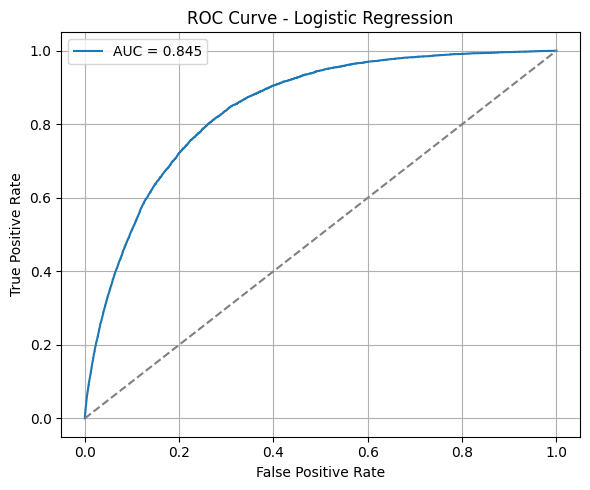

In [63]:
# --- Step 7: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#RANDOM FOREST

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [65]:
# --- Step 1: Prepare data
X = df_model.drop(columns='HeartDisease')
y = df_model['HeartDisease']

# --- Step 2: Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [66]:
# --- Step 3: Oversample
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


In [68]:
# --- Step 4: Hyperparameter Tuning
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

rf_search.fit(X_resampled, y_resampled)
rf_model = rf_search.best_estimator_

print("\nBest Parameters:", rf_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}


In [69]:
# --- Step 5: Evaluate
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print("\n=== Random Forest Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("F1 Score:", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


=== Random Forest Results ===
Accuracy: 0.8776970260433792
AUC: 0.746999167639026
F1 Score:               precision    recall  f1-score   support

         0.0       0.92      0.94      0.93     80472
         1.0       0.25      0.19      0.22      7727

    accuracy                           0.88     88199
   macro avg       0.59      0.57      0.58     88199
weighted avg       0.87      0.88      0.87     88199

Confusion Matrix:
 [[75906  4566]
 [ 6221  1506]]


/tmp/ipython-input-70-778691036.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='crest')


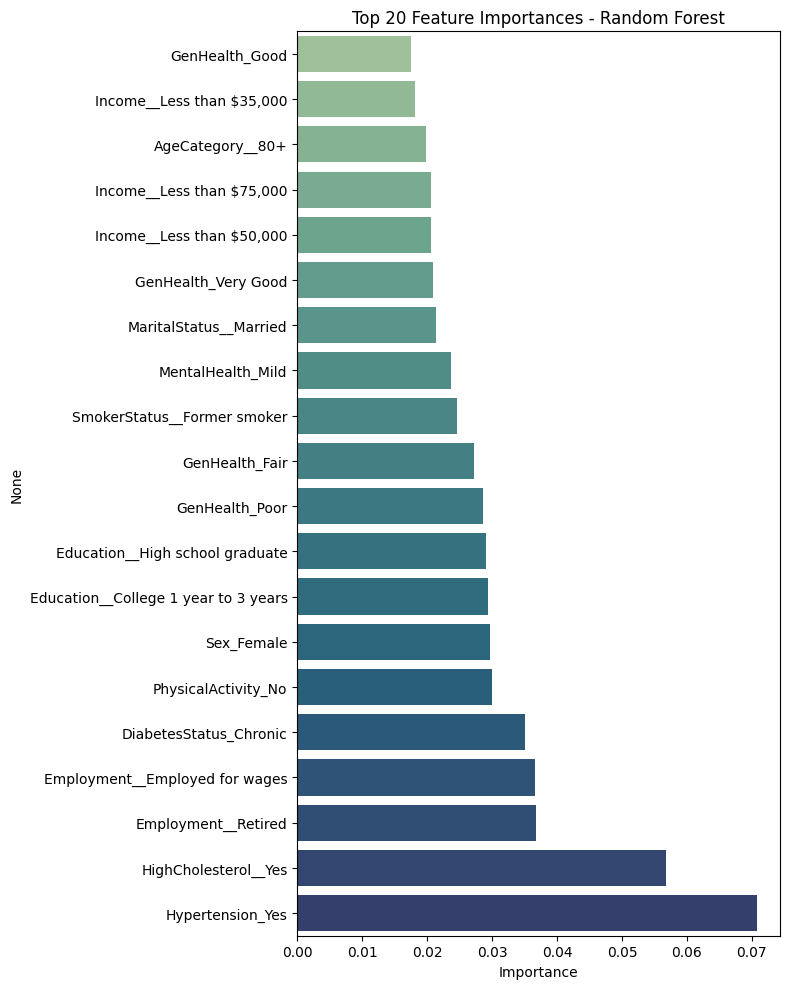

In [70]:
# --- Step 6: Feature Importance Plot
feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=True).tail(20)

plt.figure(figsize=(8, 10))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='crest')
plt.title("Top 20 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


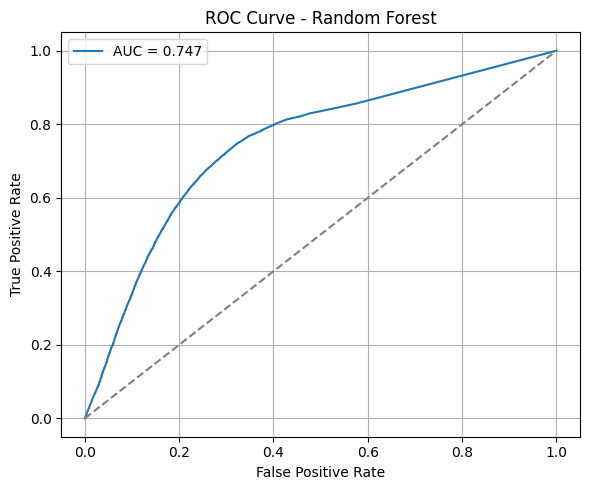

In [71]:
# --- Step 7: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
feat_imp.sort_values(ascending=False).to_csv("rf_feature_importance.csv", header=['Importance'])

##XG BOOST

In [72]:

import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
# --- Step 1: Prepare data
X = df_model.drop(columns='HeartDisease')
y = df_model['HeartDisease']

# --- Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [74]:
# --- Step 3: Calculate scale_pos_weight
# This helps XGBoost handle imbalance natively
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# --- Step 4: Train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:25:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)


=== XGBoost (No Resampling) Results ===
Accuracy: 0.7372532568396467
AUC: 0.8464994147767464
              precision    recall  f1-score   support

         0.0       0.98      0.73      0.84     80472
         1.0       0.22      0.81      0.35      7727

    accuracy                           0.74     88199
   macro avg       0.60      0.77      0.59     88199
weighted avg       0.91      0.74      0.79     88199

Confusion Matrix:
 [[58747 21725]
 [ 1449  6278]]


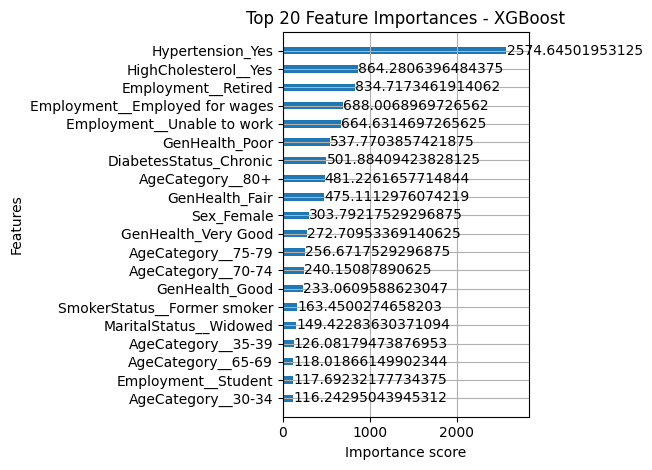

In [75]:
# --- Step 5: Evaluate
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("\n=== XGBoost (No Resampling) Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- Step 6: Feature importance
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=20, height=0.4)
plt.title("Top 20 Feature Importances - XGBoost")
plt.tight_layout()
plt.show()


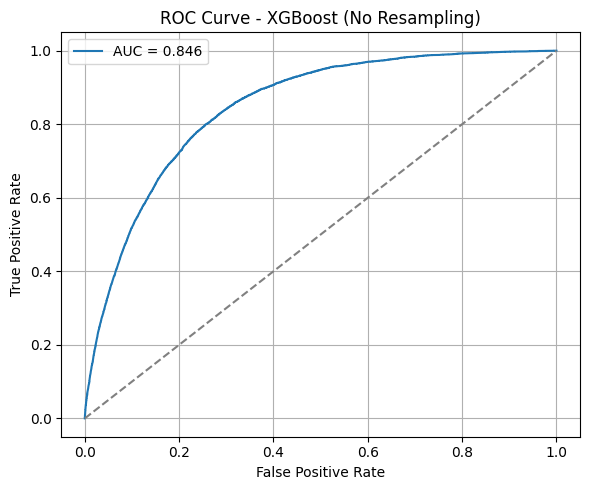

In [76]:
# --- Step 7: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost (No Resampling)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#XG Boost with random sampler

In [77]:
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb

# --- Step 1: Prepare data
X = df_model.drop(columns='HeartDisease')
y = df_model['HeartDisease']

# --- Step 2: Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [78]:
# --- Step 3: Oversample
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# --- Step 4: Train XGBoost
xgb_model_ros = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

xgb_model_ros.fit(X_resampled, y_resampled)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:26:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [79]:
# --- Step 5: Evaluate
y_pred = xgb_model_ros.predict(X_test)
y_proba = xgb_model_ros.predict_proba(X_test)[:, 1]

print("\n=== XGBoost (With RandomOverSampler) Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


=== XGBoost (With RandomOverSampler) Results ===
Accuracy: 0.7390559983673284
AUC: 0.8465072178392341
              precision    recall  f1-score   support

         0.0       0.98      0.73      0.84     80472
         1.0       0.23      0.81      0.35      7727

    accuracy                           0.74     88199
   macro avg       0.60      0.77      0.59     88199
weighted avg       0.91      0.74      0.79     88199

Confusion Matrix:
 [[58913 21559]
 [ 1456  6271]]


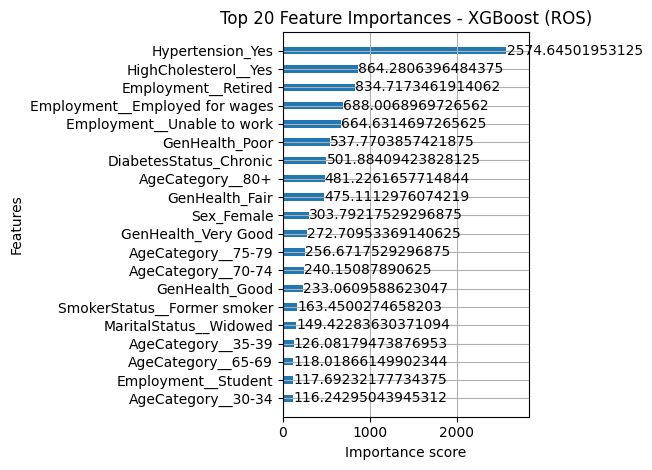

In [80]:
# --- Step 6: Feature importance
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=20, height=0.4)
plt.title("Top 20 Feature Importances - XGBoost (ROS)")
plt.tight_layout()
plt.show()

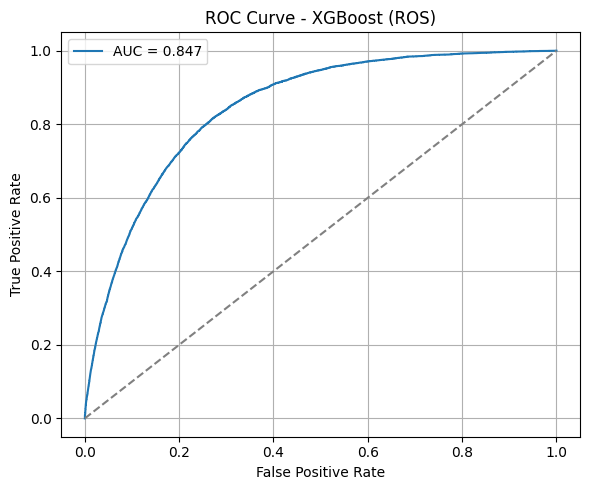

In [81]:
# --- Step 7: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost (ROS)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#COMPARIOSN OF THREE MODELS

In [82]:
from sklearn.metrics import f1_score

# --- Get metrics for each model

results = []

# Logistic Regression
lr_f1 = f1_score(y_test, log_model.predict(X_test_scaled), average='macro')
results.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, log_model.predict(X_test_scaled)),
    'ROC AUC': roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1]),
    'F1 (Macro)': lr_f1
})

# Random Forest
rf_f1 = f1_score(y_test, rf_model.predict(X_test), average='macro')
results.append({
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, rf_model.predict(X_test)),
    'ROC AUC': roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]),
    'F1 (Macro)': rf_f1
})

# XGBoost (No Resampling)
xgb1_f1 = f1_score(y_test, xgb_model.predict(X_test), average='macro')
results.append({
    'Model': 'XGBoost (No ROS)',
    'Accuracy': accuracy_score(y_test, xgb_model.predict(X_test)),
    'ROC AUC': roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]),
    'F1 (Macro)': xgb1_f1
})

# XGBoost (With Resampling)
xgb2_f1 = f1_score(y_test, xgb_model_ros.predict(X_test), average='macro')
results.append({
    'Model': 'XGBoost (With ROS)',
    'Accuracy': accuracy_score(y_test, xgb_model_ros.predict(X_test)),
    'ROC AUC': roc_auc_score(y_test, xgb_model_ros.predict_proba(X_test)[:, 1]),
    'F1 (Macro)': xgb2_f1
})

# --- Show results
df_results = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
print("\n=== Model Comparison Summary ===")
print(df_results)

# --- Optional: Save
df_results.to_csv("model_comparison_summary.csv", index=False)



=== Model Comparison Summary ===
                 Model  Accuracy   ROC AUC  F1 (Macro)
3   XGBoost (With ROS)  0.739056  0.846507    0.594659
2     XGBoost (No ROS)  0.737253  0.846499    0.593335
0  Logistic Regression  0.744079  0.844735    0.597223
1        Random Forest  0.877697  0.746999    0.575968


In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x='Model', y='ROC AUC', data=df_results, palette='viridis')
plt.title("ROC AUC Comparison")
plt.ylim(0.5, 1.0)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()
